In [6]:
# Updated imports for 2025 standards
import numpy as np
import pandas as pd  # Recommended for data handling
from util import load_hypocenters, PuuOo, load_puuoo_eqs
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# ANSS Data (1960 - 2018)

In [7]:
csv_path = 'KilaueaHypocentersANSS.csv'

In [8]:
time, lat, lon, depth, mag = load_hypocenters(csv_path)

In [9]:
print('Earliest eq:', min(time))
print('Latest eq:', max(time))
print('No. of events:', len(time))

Earliest eq: 1960-01-19 04:26:50
Latest eq: 2019-10-04 01:52:34
No. of events: 18689


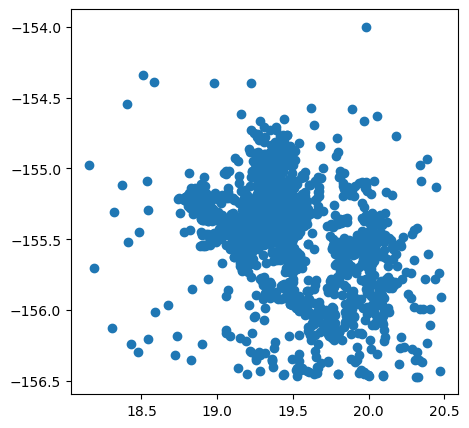

In [10]:
plt.figure(figsize=(5,5))
plt.scatter(lat, lon)
plt.show()

# WOVODAT PuuOo Data

In [11]:
eruption_csv_path = 'PuuOo.csv'
eq_csv_path       = 'puuoo_earthquakes.csv' 

p = PuuOo(eruption_csv_path)
time, lat, lon, depth, mag = load_puuoo_eqs(eq_csv_path)
print(time[1], depth.shape)

1983-01-01 00:43:33 (6485,)


In [12]:
# Try some random times. Was PuuOo erupting?
print(time[1000], p.was_erupting(time[1000]))
print(p.was_erupting(time[680]))

# Special case for time < time of first eruption
print('\nSpecial case:')
print(p.was_erupting(time[0]))
p.was_erupting(time[0], verbose=True)

1983-05-26 07:07:49 False
True

Special case:
False
Time 1983-01-01 00:18:51 is before eruption history begins


False

### Remove eqs that happened before eruption history

In [13]:
from itertools import compress

def prune_data(time, lat, lon, depth, mag, puuoo):
    """
    Prune data by removing all eqs that happened before eruption catalogue starts
    WARNING: be careful with datatypes (assumes you want list for time and numpy array for other vars)
    """

    idx = [puuoo.was_erupting(t) is not None for t in time]
    
    time    = list(compress(time, idx))
    lat   = np.array(list(compress(lat, idx)))
    lon   = np.array(list(compress(lon, idx)))
    depth = np.array(list(compress(depth, idx)))
    mag   = np.array(list(compress(mag, idx)))
    
    return time, lat, lon, depth, mag

In [14]:
print(len(time))
time, lat, lon, depth, mag = prune_data(time, lat, lon, depth, mag, p)
print(len(time))

6485
6485


In [15]:
# Make additional array for erupting or not
erupt = np.array([p.was_erupting(t) for t in time])
erupt.shape

(6485,)

### Plot some things

In [ ]:
np.sum(erupt==True)

np.int64(1236)

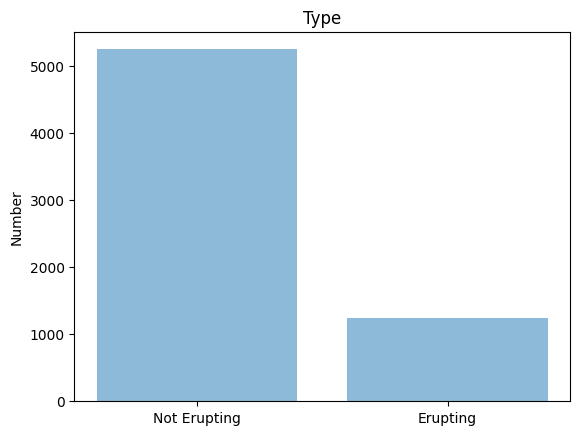

In [ ]:
# Number of events
labels = ('Not Erupting', 'Erupting')
y_pos = np.arange(len(labels))
vals = [np.sum(erupt==False), np.sum(erupt==True)]

plt.bar(y_pos, vals, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Number')
plt.title('Type')

plt.show()


"long vs lat graph"

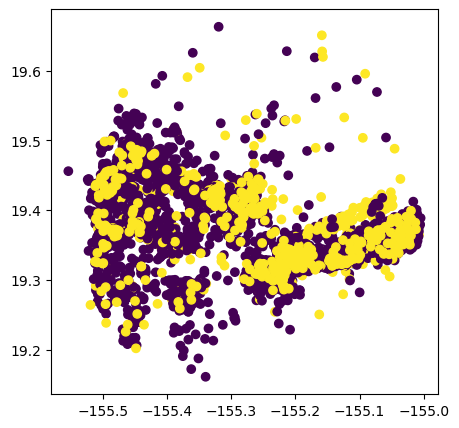

In [ ]:
# Geographic distribution
c = [1 if val==True else 0 for val in erupt]
plt.figure(figsize=(5,5))
plt.scatter(lon, lat, c=c)
plt.show()

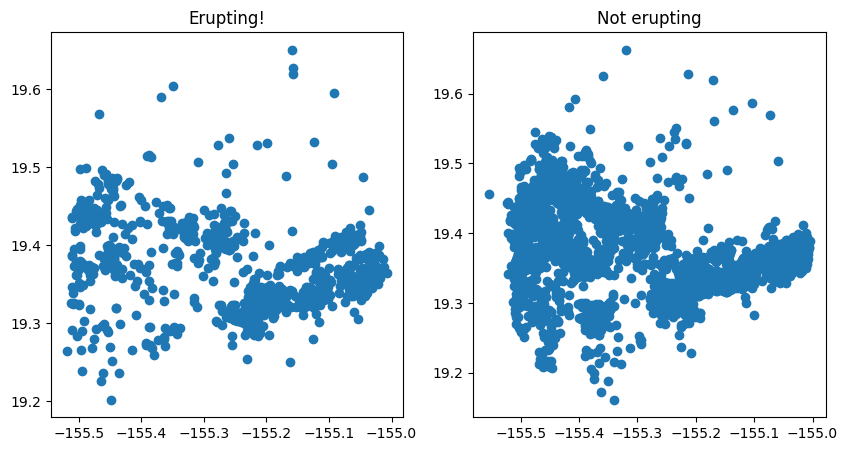

In [ ]:
# Pull apart data
lon_erupt   = np.array(list(compress(lon, erupt)))
lat_erupt   = np.array(list(compress(lat, erupt)))

lon_repose   = np.array(list(compress(lon, (1 - erupt))))
lat_repose   = np.array(list(compress(lat, (1 - erupt))))

plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.scatter(lon_erupt, lat_erupt)
plt.title('Erupting!')
ax1 = plt.subplot(122)
plt.scatter(lon_repose, lat_repose)
plt.title('Not erupting')
plt.show()

## Machine Learning!
Here's how to run random forest. So easy!! My suspicion is that this model is overfitting the training set, but we need to construct a validation/test set to really know.

In [20]:
# Prepare features and labels for ML
timestamp = np.array([t.timestamp() for t in time])
X = np.vstack((timestamp, lat, lon, depth, mag)).T
Y = np.array([1 if val==True else 0 for val in erupt])
print('Feature shape:', X.shape)
print('Label shape:', Y.shape)
# Split data for validation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Feature shape: (6485, 5)
Label shape: (6485,)


In [21]:
# Fit Random Forest with reproducibility
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
rf.fit(X_train, Y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [22]:
# Updated accuracy function using sklearn
def get_accuracy(model, X, Y):
    pred = model.predict(X)
    return accuracy_score(Y, pred)

In [23]:
# Evaluate model
print("Train accuracy:", get_accuracy(rf, X_train, Y_train))
print("Test accuracy:", get_accuracy(rf, X_test, Y_test))
print("\nNaive model would get:", np.sum(1-Y)/Y.shape[0])
print('\nFeature importances:', rf.feature_importances_)

Train accuracy: 0.9951811873554356
Test accuracy: 0.9414032382420972

Naive model would get: 0.8094063222821897

Feature importances: [0.6240026  0.09891998 0.10766897 0.10706749 0.06234096]


### Can we get the same performance without time?

In [24]:
# Try without time feature
X = np.vstack((lat, lon, depth, mag)).T
Y = np.array([1 if val==True else 0 for val in erupt])
print('Feature shape:', X.shape)
print('Label shape:', Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Feature shape: (6485, 4)
Label shape: (6485,)


In [25]:
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
rf.fit(X_train, Y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [26]:
print("Train accuracy:", get_accuracy(rf, X_train, Y_train))
print("Test accuracy:", get_accuracy(rf, X_test, Y_test))
print("\nNaive model would get:", np.sum(1-Y)/Y.shape[0])
print('\nFeature importances:', rf.feature_importances_)

Train accuracy: 0.9865073245952197
Test accuracy: 0.8226676946800309

Naive model would get: 0.8094063222821897

Feature importances: [0.26261828 0.29069544 0.27409943 0.17258685]
